In [1]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from LRGSG_package.LRGSG import gaussian_filter, Lattice2D, \
    read_files_to_2d_array, move_to_rootf, eigV_for_lattice2D,\
    create_symmetric_log_bins, bin_eigenvalues
from matplotlib.ticker import SymmetricalLogLocator
#
move_to_rootf()
plt.style.use("ipynb/nb_plotsheet.mplstyle")

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [13]:
pflip = 0.39
nAvg = 10000
howmany = 1
mode = 'scipy'
geo = 'squared'
sgpath = "plot/paper/suppinf/spectra_test_1/"

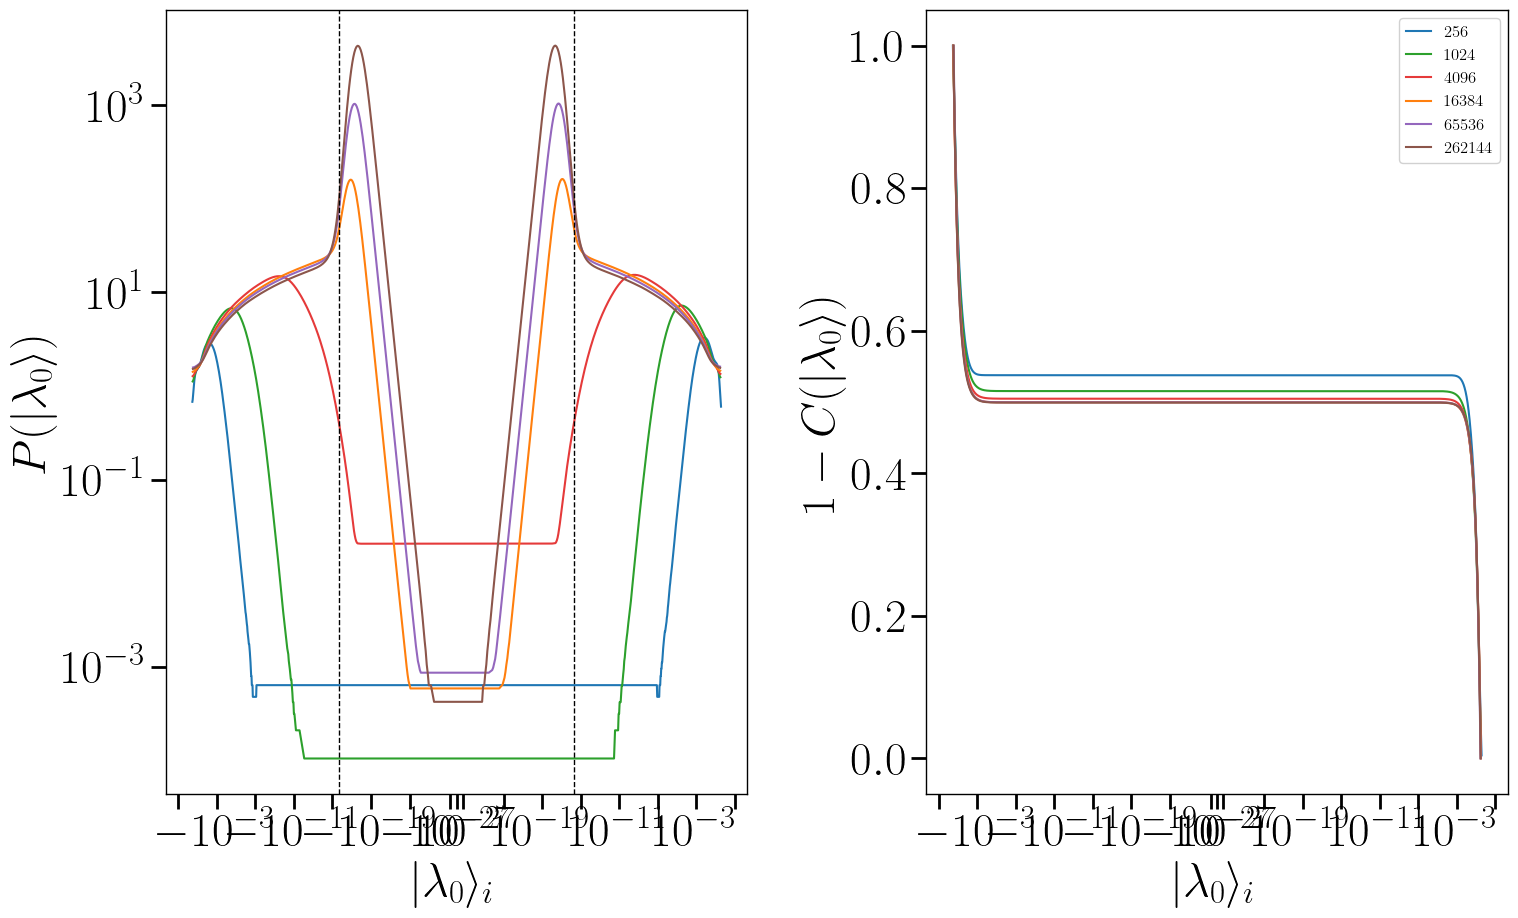

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 10))
for side in [16, 32, 64, 128, 256, 512]:
    l = Lattice2D(side, geo,
                  pflip=pflip,
                  sgpath=sgpath)
    #
    workDir = l.spectpath
    fnameBase = f"dist{howmany}_{pflip:.3g}_{mode}"
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    #
    try:
        with open(fname, "rb") as f:
            listOfCounters = pk.load(f)
    except FileNotFoundError:
        navgdone, _ = os.path.splitext(
            find_matching_files(workDir, fnameBase)[0].split('_')[-1])
        navgdone = int(navgdone)
        fname = f"{workDir}{fnameBase}_{navgdone}.pkl"
        with open(fname, "rb") as f:
            listOfCounters = pk.load(f)
    minval = 1e-2
    for ii,i in enumerate(listOfCounters):
        k, v = zip(*sorted(dict(i).items()))
        #
        smoothed_y = gaussian_filter(v, sigma=4)
        normalized_y = smoothed_y / np.trapz(smoothed_y, k)
        cumulative_y = np.cumsum(normalized_y * np.diff(k, prepend=k[0]))
        #
        ax[0].plot(k, normalized_y, '-', label=f"{l.N}")
        ax[1].plot(k, 1-cumulative_y, '-', label=f"{l.N}")
        if np.min(np.abs(k)) < minval:
            minval = np.min(np.abs(k))

# fig.suptitle(fr"N={side**2}, {mode}, $p={pflip}$, {geo} #{nAvg}")
# ax[0].title(fr"$P(|\lambda_0\rangle)$")
# ax[1].title(fr"$C(|\lambda_0\rangle)$")



for axx in ax:
    locator = SymmetricalLogLocator(linthresh=minval/10, subs=[1.0], base=10)
    axx.set_xscale('symlog', linthresh=minval/10)
    axx.xaxis.set_major_locator(locator)
    labels = axx.get_xticklabels()
    # Set visibility of every second label to False
    for label in labels[::2]:
        if label.get_text() == '$\\mathdefault{0}$':
            continue
        label.set_visible(False)
    axx.set_xlabel(r"$|\lambda_0\rangle_i$")
    # axx.legend(ncol=2)


ax[0].axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
ax[0].axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
ax[0].set_yscale('log')
ax[0].set_ylabel(fr"$P(|\lambda_0\rangle)$")
ax[1].set_ylabel(fr"$1-C(|\lambda_0\rangle)$")


ax[1].legend()
fig.tight_layout()
fig.savefig(f"data/{sgpath}dist_{side}_{pflip:.3g}_{nAvg}.png", 
            bbox_inches='tight', transparent=True)
# plt.show()

In [7]:
workDir

'data/plot/paper/suppinf/spectra_test_1/l2d_squared/spect/N=262144/'

### Smallest eigenvalue Signed Laplacian

In [ ]:
geo = 'squared'
#
nAvg = 500
bins_count = 500
period = 20
workDir = "data/plot/dev_tool_Lattice2D/"
os.makedirs(workDir, exist_ok=True)
for mode in ['scipy', 'numpy']:
    for side in [16, 32, 64]:
        for pflip in [0.01, 0.05, 0.103, 0.2]:
            #
            fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
            fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

            if not os.path.exists(fname):
                # Setup and initial calculation
                initial_eig = np.abs(eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode))
                bins, bin_centers = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), bins_count)

                bin_counter = Counter()
                fnameOld = ""
                nAvgDone = 0
                fnameExists = glob.glob(f"{workDir}{fnameBase}*")
                if fnameExists:
                    nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
                    fnameOld = fnameExists[0]
                nAvgNeed = nAvg - nAvgDone
                for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
                    batch_size = min(nAvgNeed - current_period * period, period)
                    eig_values = np.concatenate([eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
                    bin_counter.update(bin_eigenvalues(eig_values, bins, bin_centers))
                    fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
                    try:
                        os.rename(fnameOld, fnameNew)
                    except FileNotFoundError:
                        pass
                    with open(fnameNew, "wb") as f:
                        pk.dump(dict(bin_counter), f)
                    fnameOld = fnameNew

                # At the end, save the final state if needed
                if nAvgNeed % period:
                    fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
                    os.rename(fnameOld, fnameNew)
                    with open(fnameNew, "wb") as f:
                        pk.dump(dict(bin_counter), f)


In [ ]:

pflip = 0.2

In [ ]:
for side in [16, 32, 64, 96]:
    mode = 'scipy'
    fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    with open(fname, "rb") as f:
        k, v = zip(*sorted(pk.load(f).items()))
    plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
    plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
    plt.plot(k, v, 'o')

    plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
    plt.xscale('symlog', linthresh=1e-17)
    plt.yscale('log')
    plt.xlabel(r"$|\lambda_0\rangle_i$")
    plt.ylabel(r"$P(|\lambda_0\rangle_i)$")
    # plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}.png")
    plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    # k, v = zip(*sorted(pk.load(f).items()))
pflip = 0.5
nAvg = 10000
howmany = 1
mode = 'scipy'
geo = 'squared'
for side in [16, 32, 64, 128, 256, 512]:
# howmany = 1
    l = Lattice2D(side, pflip=pflip, geo=geo, sgpath="cluster_data/spectra_test_1/")
    fnameBase = f"dist{howmany}_{pflip:.3g}_{mode}"
    workDir = l.spectpath
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    try:
        with open(fname, "rb") as f:
            listOfCounters = pk.load(f)
    except FileNotFoundError:
        navgdone, _ = os.path.splitext(find_matching_files(workDir, fnameBase)[0].split('_')[-1])
        navgdone = int(navgdone)
        fname = f"{workDir}{fnameBase}_{navgdone}.pkl"
        with open(fname, "rb") as f:
            listOfCounters = pk.load(f)
    minval = 1e-2
    for ii,i in enumerate(listOfCounters):
        k, v = zip(*sorted(dict(i).items()))
        smoothed_y = gaussian_filter(v, sigma=2)
        area = np.trapz(smoothed_y, k)
        normalized_y = smoothed_y / area
        cumulative_y = np.cumsum(normalized_y * np.diff(k, prepend=k[0]))

        ax[0].plot(k, normalized_y, '-', label=f"{ii:.3g}")
        ax[1].plot(k, cumulative_y, '-', label=f"{ii:.3g}")
        if np.min(np.abs(k)) < minval:
            minval = np.min(np.abs(k))

fig.suptitle(fr"N={side**2}, {mode}, $p={pflip}$, {geo} #{nAvg}")
# ax[0].title(fr"$P(|\lambda_0\rangle)$")
# ax[1].title(fr"$C(|\lambda_0\rangle)$")

for axx in ax:
    locator = SymmetricalLogLocator(linthresh=minval/10, subs=[1.0], base=10)
    axx.set_xscale('symlog', linthresh=minval/10)
    axx.xaxis.set_major_locator(locator)
    labels = axx.get_xticklabels()
    # Set visibility of every second label to False
    for label in labels[::2]:
        if label.get_text() == '$\\mathdefault{0}$':
            continue
        label.set_visible(False)
    axx.set_xlabel(r"$|\lambda_0\rangle_i$")
    # axx.legend(ncol=2)


ax[0].axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
ax[0].axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
ax[0].set_yscale('log')
ax[0].set_ylabel(fr"$P(|\lambda_0\rangle)$")
ax[1].set_ylabel(fr"$C(|\lambda_0\rangle)$")

labels = []
handles = []
for a in ax:
    for handle, label in zip(*a.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

# ax[1].set_yscale('log')
plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}.png")
# plt.show()

In [ ]:
pflip = 0.2

In [ ]:
for side in [16, 32, 64]:
    mode = 'scipy'
    fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    with open(fname, "rb") as f:
        k, v = zip(*sorted(pk.load(f).items()))
    plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
    plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
    plt.plot(k, v, 'o')
    #
    mode = 'numpy'
    fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    with open(fname, "rb") as f:
        k, v = zip(*sorted(pk.load(f).items()))
    plt.plot(k, v, 'o')

    plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
    plt.xscale('symlog', linthresh=1e-17)
    plt.yscale('log')
    plt.xlabel(r"$|\lambda_0\rangle_i$")
    plt.ylabel(r"$P(|\lambda_0\rangle_i)$")
    # plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}.png")
    plt.show()

#### $\min|\lambda_0\rangle$

In [ ]:
mode = 'scipy'
pflip = 0.
for side in [16, 32, 64, 96]:
    fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
    fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
    with open(fname, "rb") as f:
        k, v = zip(*sorted(pk.load(f).items()))
    plt.plot(side**2, min(np.abs(k)), 'o' , label=f"{side**2}")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig(f"{workDir}minl0_{pflip:.3g}_{nAvg}.png")

In [ ]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from LRGSG_package.LRGSG import gaussian_filter, Lattice2D, \
    read_files_to_2d_array, move_to_rootf
#
move_to_rootf(True)

In [ ]:
plt.figure()
for p in np.linspace(0.01, 0.5, num=20):
    stdarr = []
    for na in range(100):
        l = Lattice2D(32, pflip=p, geo='squared')
        l.flip_random_fract_edges()
        l.compute_k_eigvV(MODE_dynspec='numpy')
        stdarr.append(np.std(np.diff(l.eigv)))
    plt.scatter(p, np.mean(stdarr), marker='o', c='k')

In [ ]:
p=0.5
l = Lattice2D(128, pflip=p, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='numpy')


In [ ]:
plt.plot(l.eigv)

In [ ]:
plt.plot(np.diff(l.eigv))

In [ ]:
side = 32
for p in np.linspace(0.01, 0.5):
    l = Lattice2D(side, pflip=p, geo='squared')
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    matrix1 = l.sLp.todense().astype(np.float64)
    V1, E1 = l.eigv, l.eigV.T
    np.allclose(matrix1 @ V1, V1 @ np.diag(E1))

In [ ]:

# Setup and initial calculation
initial_eig = np.abs(eigV_for_lattice(side, pflip=pflip, geo=geo, mode=mode))
bins, bin_centers = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), bins_count)

bin_counter = Counter()
fnameOld = ""
if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
        fnameOld = fnameExists[0]
    nAvgNeed = nAvg - nAvgDone
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins, bin_centers))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = fnameNew

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


In [ ]:
mode = 'scipy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
with open(fname, "rb") as f:
    k, v = zip(*sorted(pk.load(f).items()))
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.plot(k, v, 'o')
#
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
with open(fname, "rb") as f:
    k, v = zip(*sorted(pk.load(f).items()))
plt.plot(k, v, 'o')

plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')
plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}.png")

In [ ]:
def eigV_for_lattice(side, mode='scipy', **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec=mode)
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 2):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))
def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [ ]:
# Setup
side = 64
geo = 'squared'
pflip = 0.103
#
nAvg = 200
bins_count = 500
period = 20
#
workDir = "data/plot/dev_tool_Lattice2D/"
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

In [ ]:
# Get initial eigenvalues to define bins
initial_eig = np.abs(eigV_for_lattice(side, pflip=pflip, geo=geo, mode=mode))
print(np.log10(np.max(initial_eig))+4)
bins = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), 
                                 bins_count)
#
bin_counter = Counter()
fnameOld = ""
if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
        fnameOld = fnameExists[0]
    nAvgNeed = nAvg - nAvgDone
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = fnameNew

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)

In [ ]:
mode = 'scipy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
k,v = zip(*pk.load(open(fname, "rb")).items())
binsv = bins[np.array(k)-1]
plt.plot(binsv, v, 'o')
#
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
k,v = zip(*pk.load(open(fname, "rb")).items())
binsv = bins[np.array(k)-1]
plt.plot(binsv, v, 'o')
#
plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')
plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}_{mode}.png")

In [ ]:
l = Lattice2D(128, pflip=0.103, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='scipy')
np.max(flip_to_positive_majority(l.eigV[0]))

In [ ]:
l = Lattice2D(64, pflip=0.103, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='scipy')
#
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0].flatten()))
plt.plot(outp[0], outp[1], marker='o', lw=1)
plt.plot(outm[0], outm[1], marker='o', lw=1)
plt.xscale('symlog', linthresh=1e-20)
plt.yscale('log')
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)

### phtra plot

In [ ]:
perc = pd.read_csv("/home/opisthofulax/PhD/projects/complex-networks/LRG-Signed/data/plot/tmp/OrderP_L64",
                       sep=',', header=None)
l = Lattice2D(64, geo='squared', 
            initNwDict=True, 
            with_positions=False,
            sgpath="plot/paper/suppinf/phase_transition_l2d/"
)
data = read_files_to_2d_array(l.phtrapath, 'rand')
data = data[np.argsort(data[:, 0])]
#
pinf2 = gaussian_filter(data[:, 5], sigma=2)
#
chi = gaussian_filter(data[:, 7]*l.N, sigma=1)
#
x_scaled = data[:, 0]
#
chi_scaled = gaussian_filter(perc[3]*64**2,sigma=0)

chiplot, = plt.plot(perc[5], chi_scaled,
                          lw=2, marker='')
chiplot, = plt.plot(x_scaled, chi,
                          lw=2, marker='')

### precision problems

In [ ]:
np.random.seed(0)
random.seed(0)
#
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(35, 7))
#
l = Lattice2D(128, pflip=0.103)
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=5, MODE_dynspec="scipy", typf=np.float32)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red', 'white'])
for i in range(5):
    ei = flip_to_positive_majority(l.eigV[i].reshape(l.syshape))
    result = sign_with_threshold(ei, threshold=1e-7)
    ax[i].imshow(result, cmap=cmap, interpolation=None)

np.random.seed(0)
random.seed(0)
l = Lattice2D(128, pflip=0.103)
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=5, MODE_dynspec="numpy", typf=np.float64)
for i in range(5,10):
    ei = flip_to_positive_majority(l.eigV[i].reshape(l.syshape))
    result = sign_with_threshold(ei, threshold=1e-15)
    ax[i].imshow(result, cmap=cmap, interpolation=None)

In [ ]:
np.random.seed(0)
random.seed(0)
fig, ax = plt.subplots(ncols=5, figsize=(35,7))


In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(35,35))
for i in range(10):
    l = Lattice2D(128, pflip=0.12)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(howmany=2)
    ei = l.eigV[0].reshape(l.syshape)
    result = sign_with_threshold(ei, threshold=1e-15)
    ax[i//5][i%5].imshow(result, cmap=cmap, interpolation=None)

In [ ]:
k, v = l.cluster_distribution_list().keys(), l.cluster_distribution_list().values()
plt.plot(k, v, marker='o', lw=0)
plt.yscale('log')
plt.xscale('log')

### Distribution of values first eigenstate

In [ ]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from LRGSG_package.LRGSG import gaussian_filter, Lattice2D, \
    read_files_to_2d_array, move_to_rootf
#
move_to_rootf(True)

In [ ]:
l = Lattice2D(64, pflip=0.1, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='numpy')

In [ ]:
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0].flatten()))
plt.plot(outp[0], outp[1], marker='o', lw=1)
plt.plot(outm[0], outm[1], marker='o', lw=1)
plt.xscale('symlog', linthresh=1e-20)
plt.yscale('log')
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)

In [ ]:
def flip_edges_optimized(graph, fraction=0.5):
    """
    Flips the sign of a fraction of the +1 edges in the graph to -1 using more concise NetworkX functions.

    Parameters:
    - graph: A networkx graph where edges have a 'weight' attribute.
    - fraction: Fraction of +1 weighted edges to flip. Value between 0 and 1.

    Returns:
    - The modified graph with some edges flipped.
    """
    # Ensure the fraction is between 0 and 1
    if not (0 <= fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Find all edges with weight +1
    
    # Calculate the number of edges to flip
    num_to_flip = int(graph.number_of_edges() * fraction)
    
    # Randomly select a subset of positive edges to flip
    edges_to_flip = random.sample(list(graph.edges()), k=num_to_flip)
    
    # Prepare a dictionary with the selected edges and their new weight
    flipped_edges = {graph[i][j]: -1 for (i, j) in edges_to_flip}
    
    # Use set_edge_attributes to apply the new weights
    nx.set_edge_attributes(graph, flipped_edges, 'weight')
    
    return graph

In [ ]:
G = nx.grid_2d_graph(128, 128, periodic=True)
nx.set_edge_attributes(G, +1, 'weight')
flip_edges_optimized(G, 0.5)

In [ ]:
G[(0, 0)][(0, 1)]

In [ ]:


# plt.xlim(-1.5, 1)

In [ ]:
np.where(np.isnan(l.eigV[0].flatten()))

In [ ]:
np.isnan(np.logl.eigV[0].flatten()).any()